<a href="https://colab.research.google.com/github/krishna23-45/genrate/blob/main/genrate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
module_path = 'https://tfhub.dev/deepmind/bigbigan-resnet50/1'

In [ ]:

import io
import IPython.display
import PIL.Image
from pprint import pformat

import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_hub as hub


In [ ]:
def imgrid(imarray, cols=4, pad=1, padval=255, row_major=True):
  """Lays out a [N, H, W, C] image array as a single image grid."""
  pad = int(pad)
  if pad < 0:
    raise ValueError('pad must be non-negative')
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = N // cols + int(N % cols != 0)
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=padval)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*W, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

def interleave(*args):
  """Interleaves input arrays of the same shape along the batch axis."""
  if not args:
    raise ValueError('At least one argument is required.')
  a0 = args[0]
  if any(a.shape != a0.shape for a in args):
    raise ValueError('All inputs must have the same shape.')
  if not a0.shape:
    raise ValueError('Inputs must have at least one axis.')
  out = np.transpose(args, [1, 0] + list(range(2, len(a0.shape) + 1)))
  out = out.reshape(-1, *a0.shape[1:])
  return out

def imshow(a, format='png', jpeg_fallback=True):
  """Displays an image in the given format."""
  a = a.astype(np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(a).save(data, format)
  im_data = data.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def image_to_uint8(x):
  """Converts [-1, 1] float array to [0, 255] uint8."""
  x = np.asarray(x)
  x = (256. / 2.) * (x + 1.)
  x = np.clip(x, 0, 255)
  x = x.astype(np.uint8)
  return x

In [ ]:
module = hub.Module(module_path)  # inference

for signature in module.get_signature_names():
  print('Signature:', signature)
  print('Inputs:', pformat(module.get_input_info_dict(signature)))
  print('Outputs:', pformat(module.get_output_info_dict(signature)))
  print()

Signature: discriminate
Inputs: {'x': <hub.ParsedTensorInfo shape=(?, 128, 128, 3) dtype=float32 is_sparse=False>,
 'z': <hub.ParsedTensorInfo shape=(?, 120) dtype=float32 is_sparse=False>}
Outputs: {'score_x': <hub.ParsedTensorInfo shape=(?,) dtype=float32 is_sparse=False>,
 'score_xz': <hub.ParsedTensorInfo shape=(?,) dtype=float32 is_sparse=False>,
 'score_z': <hub.ParsedTensorInfo shape=(?,) dtype=float32 is_sparse=False>}

Signature: default
Inputs: {'x': <hub.ParsedTensorInfo shape=(?, 256, 256, 3) dtype=float32 is_sparse=False>}
Outputs: {'default': <hub.ParsedTensorInfo shape=(?, 120) dtype=float32 is_sparse=False>}

Signature: encode
Inputs: {'x': <hub.ParsedTensorInfo shape=(?, 256, 256, 3) dtype=float32 is_sparse=False>}
Outputs: {'avepool_feat': <hub.ParsedTensorInfo shape=(?, 2048) dtype=float32 is_sparse=False>,
 'bn_crelu_feat': <hub.ParsedTensorInfo shape=(?, 4096) dtype=float32 is_sparse=False>,
 'default': <hub.ParsedTensorInfo shape=(?, 120) dtype=float32 is_sparse=F

In [ ]:
class BigBiGAN(object):

  def __init__(self, module):
    """Initialize a BigBiGAN from the given TF Hub module."""
    self._module = module

  def generate(self, z, upsample=False):
    """Run a batch of latents z through the generator to generate images.

    Args:
      z: A batch of 120D Gaussian latents, shape [N, 120].

    Returns: a batch of generated RGB images, shape [N, 128, 128, 3], range
      [-1, 1].
    """
    outputs = self._module(z, signature='generate', as_dict=True)
    return outputs['upsampled' if upsample else 'default']

  def make_generator_ph(self):
    """Creates a tf.placeholder with the dtype & shape of generator inputs."""
    info = self._module.get_input_info_dict('generate')['z']
    return tf.placeholder(dtype=info.dtype, shape=info.get_shape())

  def gen_pairs_for_disc(self, z):
    """Compute generator input pairs (G(z), z) for discriminator, given z.

    Args:
      z: A batch of latents (120D standard Gaussians), shape [N, 120].

    Returns: a tuple (G(z), z) of discriminator inputs.
    """
    # Downsample 256x256 image x for 128x128 discriminator input.
    x = self.generate(z)
    return x, z

  def encode(self, x, return_all_features=False):
    """Run a batch of images x through the encoder.

    Args:
      x: A batch of data (256x256 RGB images), shape [N, 256, 256, 3], range
        [-1, 1].
      return_all_features: If True, return all features computed by the encoder.
        Otherwise (default) just return a sample z_hat.

    Returns: the sample z_hat of shape [N, 120] (or a dict of all features if
      return_all_features).
    """
    outputs = self._module(x, signature='encode', as_dict=True)
    return outputs if return_all_features else outputs['z_sample']

  def make_encoder_ph(self):
    """Creates a tf.placeholder with the dtype & shape of encoder inputs."""
    info = self._module.get_input_info_dict('encode')['x']
    return tf.placeholder(dtype=info.dtype, shape=info.get_shape())

  def enc_pairs_for_disc(self, x):
    """Compute encoder input pairs (x, E(x)) for discriminator, given x.

    Args:
      x: A batch of data (256x256 RGB images), shape [N, 256, 256, 3], range
        [-1, 1].

    Returns: a tuple (downsample(x), E(x)) of discriminator inputs.
    """
    # Downsample 256x256 image x for 128x128 discriminator input.
    x_down = tf.nn.avg_pool(x, ksize=2, strides=2, padding='SAME')
    z = self.encode(x)
    return x_down, z

  def discriminate(self, x, z):
    """Compute the discriminator scores for pairs of data (x, z).

    (x, z) must be batches with the same leading batch dimension, and joint
      scores are computed on corresponding pairs x[i] and z[i].

    Args:
      x: A batch of data (128x128 RGB images), shape [N, 128, 128, 3], range
        [-1, 1].
      z: A batch of latents (120D standard Gaussians), shape [N, 120].

    Returns:
      A dict of scores:
        score_xz: the joint scores for the (x, z) pairs.
        score_x: the unary scores for x only.
        score_z: the unary scores for z only.
    """
    inputs = dict(x=x, z=z)
    return self._module(inputs, signature='discriminate', as_dict=True)

  def reconstruct_x(self, x, use_sample=True, upsample=False):
    """Compute BigBiGAN reconstructions of images x via G(E(x)).

    Args:
      x: A batch of data (256x256 RGB images), shape [N, 256, 256, 3], range
        [-1, 1].
      use_sample: takes a sample z_hat ~ E(x). Otherwise, deterministically
        use the mean. (Though a sample z_hat may be far from the mean z,
        typically the resulting recons G(z_hat) and G(z) are very
        similar.
      upsample: if set, upsample the reconstruction to the input resolution
        (256x256). Otherwise return the raw lower resolution generator output
        (128x128).

    Returns: a batch of recons G(E(x)), shape [N, 256, 256, 3] if
      `upsample`, otherwise [N, 128, 128, 3].
    """
    if use_sample:
      z = self.encode(x)
    else:
      z = self.encode(x, return_all_features=True)['z_mean']
    recons = self.generate(z, upsample=upsample)
    return recons

  def losses(self, x, z):
    """Compute per-module BigBiGAN losses given data & latent sample batches.

    Args:
      x: A batch of data (256x256 RGB images), shape [N, 256, 256, 3], range
        [-1, 1].
      z: A batch of latents (120D standard Gaussians), shape [M, 120].

    For the original BigBiGAN losses, pass batches of size N=M=2048, with z's
    sampled from a 120D standard Gaussian (e.g., np.random.randn(2048, 120)),
    and x's sampled from the ImageNet (ILSVRC2012) training set with the
    "ResNet-style" preprocessing from:

        https://github.com/tensorflow/tpu/blob/master/models/official/resnet/resnet_preprocessing.py

    Returns:
      A dict of per-module losses:
        disc: loss for the discriminator.
        enc: loss for the encoder.
        gen: loss for the generator.
    """
    # Compute discriminator scores on (x, E(x)) pairs.
    # Downsample 256x256 image x for 128x128 discriminator input.
    scores_enc_x_dict = self.discriminate(*self.enc_pairs_for_disc(x))
    scores_enc_x = tf.concat([scores_enc_x_dict['score_xz'],
                              scores_enc_x_dict['score_x'],
                              scores_enc_x_dict['score_z']], axis=0)

    # Compute discriminator scores on (G(z), z) pairs.
    scores_gen_z_dict = self.discriminate(*self.gen_pairs_for_disc(z))
    scores_gen_z = tf.concat([scores_gen_z_dict['score_xz'],
                              scores_gen_z_dict['score_x'],
                              scores_gen_z_dict['score_z']], axis=0)

    disc_loss_enc_x = tf.reduce_mean(tf.nn.relu(1. - scores_enc_x))
    disc_loss_gen_z = tf.reduce_mean(tf.nn.relu(1. + scores_gen_z))
    disc_loss = disc_loss_enc_x + disc_loss_gen_z

    enc_loss = tf.reduce_mean(scores_enc_x)
    gen_loss = tf.reduce_mean(-scores_gen_z)

    return dict(disc=disc_loss, enc=enc_loss, gen=gen_loss)

In [ ]:
bigbigan = BigBiGAN(module)

# Make input placeholders for x (`enc_ph`) and z (`gen_ph`).
enc_ph = bigbigan.make_encoder_ph()
gen_ph = bigbigan.make_generator_ph()

# Compute samples G(z) from encoder input z (`gen_ph`).
gen_samples = bigbigan.generate(gen_ph)

# Compute reconstructions G(E(x)) of encoder input x (`enc_ph`).
recon_x = bigbigan.reconstruct_x(enc_ph, upsample=True)

# Compute encoder features used for representation learning evaluations given
# encoder input x (`enc_ph`).
enc_features = bigbigan.encode(enc_ph, return_all_features=True)

# Compute discriminator scores for encoder pairs (x, E(x)) given x (`enc_ph`)
# and generator pairs (G(z), z) given z (`gen_ph`).
disc_scores_enc = bigbigan.discriminate(*bigbigan.enc_pairs_for_disc(enc_ph))
disc_scores_gen = bigbigan.discriminate(*bigbigan.gen_pairs_for_disc(gen_ph))

# Compute losses.
losses = bigbigan.losses(enc_ph, gen_ph)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

samples shape: (32, 128, 128, 3)


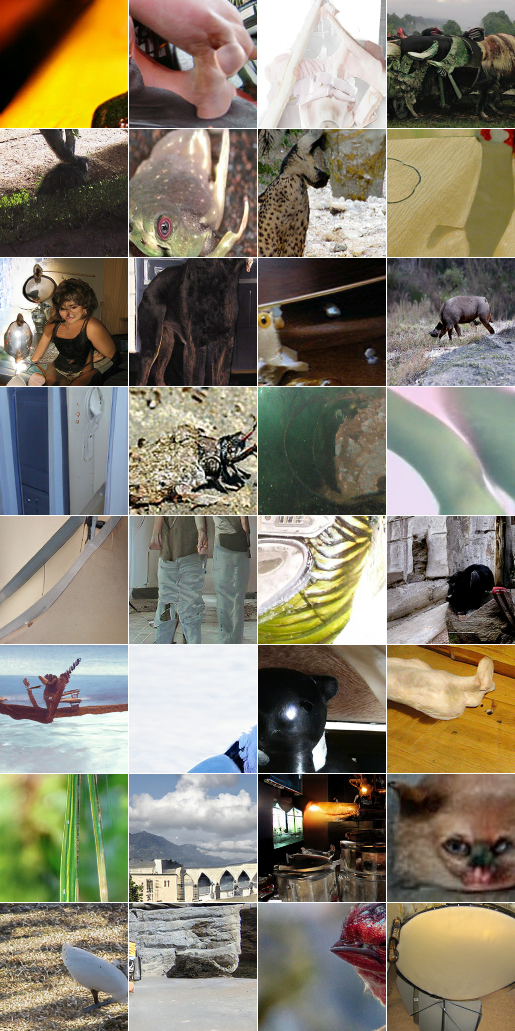

In [ ]:
feed_dict = {gen_ph: np.random.randn(32, 120)}
_out_samples = sess.run(gen_samples, feed_dict=feed_dict)
print('samples shape:', _out_samples.shape)
imshow(imgrid(image_to_uint8(_out_samples), cols=4))

In [ ]:
def get_flowers_data():
  """Returns a [32, 256, 256, 3] np.array of preprocessed TF-Flowers samples."""
  import tensorflow_datasets as tfds
  ds, info = tfds.load('tf_flowers', split='train', with_info=True)

  # Just get the images themselves as we don't need labels for this demo.
  ds = ds.map(lambda x: x['image'])

  # Filter out small images (with minor edge length <256).
  ds = ds.filter(lambda x: tf.reduce_min(tf.shape(x)[:2]) >= 256)

  # Take the center square crop of the image and resize to 256x256.
  def crop_and_resize(image):
    imsize = tf.shape(image)[:2]
    minor_edge = tf.reduce_min(imsize)
    start = (imsize - minor_edge) // 2
    stop = start + minor_edge
    cropped_image = image[start[0] : stop[0], start[1] : stop[1]]
    resized_image = tf.image.resize_bicubic([cropped_image], [256, 256])[0]
    return resized_image
  ds = ds.map(crop_and_resize)

  # Convert images from [0, 255] uint8 to [-1, 1] float32.
  ds = ds.map(lambda image: tf.cast(image, tf.float32) / (255. / 2.) - 1)

  # Take the first 32 samples.
  ds = ds.take(32)

  return np.array(list(tfds.as_numpy(ds)))

test_images = get_flowers_data()

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


reconstructions shape: (16, 256, 256, 3)
inputs_and_recons shape: (32, 256, 256, 3)


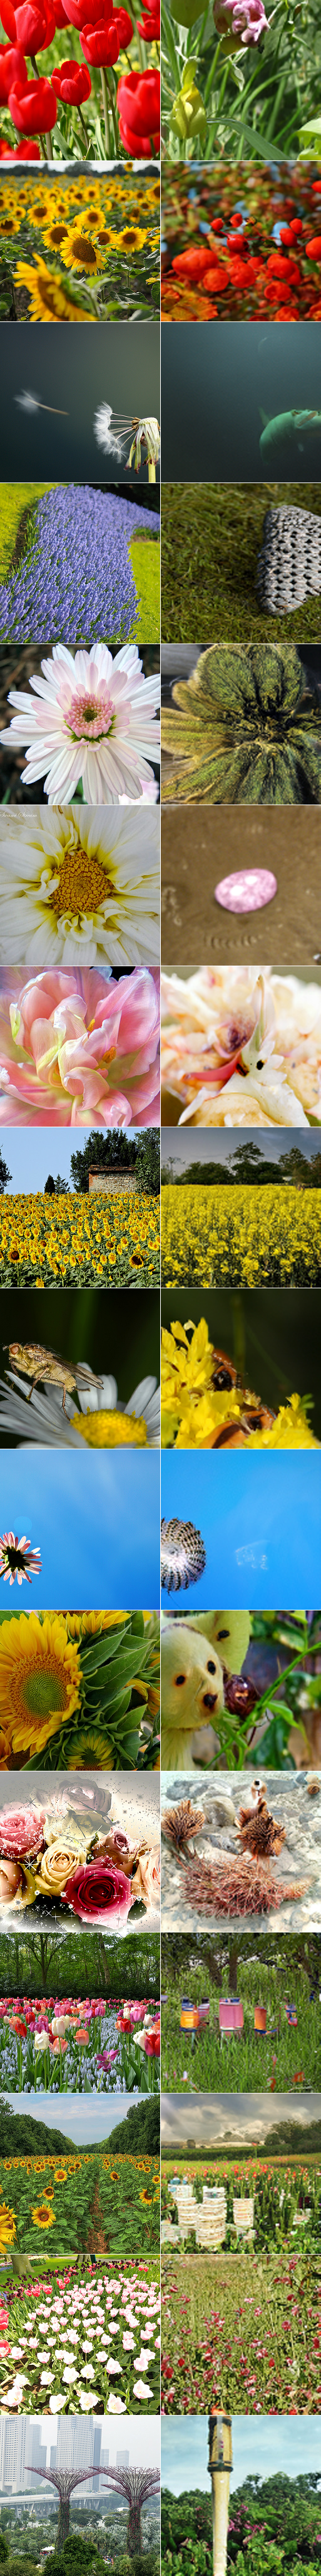

In [ ]:
test_images_batch = test_images[:16]
_out_recons = sess.run(recon_x, feed_dict={enc_ph: test_images_batch})
print('reconstructions shape:', _out_recons.shape)

inputs_and_recons = interleave(test_images_batch, _out_recons)
print('inputs_and_recons shape:', inputs_and_recons.shape)
imshow(imgrid(image_to_uint8(inputs_and_recons), cols=2))

In [ ]:

_out_features = sess.run(enc_features, feed_dict={enc_ph: test_images_batch})
print('AvePool features shape:', _out_features['avepool_feat'].shape)
print('BN+CReLU features shape:', _out_features['bn_crelu_feat'].shape)

AvePool features shape: (16, 2048)
BN+CReLU features shape: (16, 4096)


In [ ]:

feed_dict = {enc_ph: test_images, gen_ph: np.random.randn(32, 120)}
_out_scores_enc, _out_scores_gen, _out_losses = sess.run(
    [disc_scores_enc, disc_scores_gen, losses], feed_dict=feed_dict)
print('Encoder scores:', {k: v.mean() for k, v in _out_scores_enc.items()})
print('Generator scores:', {k: v.mean() for k, v in _out_scores_gen.items()})
print('Losses:', _out_losses)

Encoder scores: {'score_xz': 0.6979048, 'score_x': 1.4621634, 'score_z': -0.50387836}
Generator scores: {'score_xz': -0.9905056, 'score_x': -0.7198179, 'score_z': -0.4411625}
Losses: {'disc': 1.1825426, 'enc': 0.5506302, 'gen': 0.71716195}
